# **Dataset 2**

### **Import Packages**

In [1]:
import multiprocessing
import subprocess
import pandas as pd
from sklearn.model_selection import train_test_split

from Data_Generation.data_synthesizer import ds_generate_data
from Data_Generation.synthetic_data_vault import sdv_generate_data
from Data_Evaluation.utility import run_utility_eval
from Data_Evaluation.resemblance import pairwise_correlation_diff, jsd, wd
from Data_Evaluation.privacy import dcr, nndr, mia
from sklearn.preprocessing import LabelEncoder

### **Exploratory Data Analysis**

In [2]:
# Load the dataset as dataframe
data_path = "Original_Data/Dataset_2.csv"
original_data = pd.read_csv(data_path)
original_data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:
# Get general information about the dataset
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [4]:
# Check for missing values
original_data.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [5]:
# Check number of unique values in each column
original_data.nunique()

gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
math score                     81
reading score                  72
writing score                  77
dtype: int64

In [6]:
# Check categorical columns
categorical_cols = original_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col, original_data[col].unique())

gender ['female' 'male']
race/ethnicity ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch ['standard' 'free/reduced']
test preparation course ['none' 'completed']


### **Synthetic Data Generation**

In [7]:
# Set the start method of the multiprocessing module to 'fork' to avoid an error
multiprocessing.set_start_method('fork', force=True)

# Number of samples to generate
n = 5000

# Split the data into train and test sets (70% train, 30% test) according to evaluation paper
train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)
train_data.to_csv("Original_Data/train_data.csv", index=False)
test_data.to_csv("Original_Data/test_data.csv", index=False)

In [8]:
# !! Only use if synthetic data is not already generated !!

# Use train_data.csv to fit SDG models and generate synthetic data
# data_path = "Original_Data/train_data.csv"
# arguments = [data_path, str(n), "2"]

# print("Sampling synthpop...")
# result = subprocess.run(['Rscript', 'Data_Generation/synthpop.R',   *arguments], capture_output=True, text=True)

# print("Sampling DataSynthesizer...")
# ds_generate_data(data_path=data_path, num_samples=n, dataset_nr="2")

# sdv_generate_data(data_path=data_path, num_samples=n, dataset_nr="2")

Encode all categorical columns of both original (train+test) data and synthetic data using label encoding

In [9]:
# Load the synthetic data as dataframe
synthpop = pd.read_csv("Synthetic_Data/Dataset_2/synthpop_samples.csv")
ds = pd.read_csv("Synthetic_Data/Dataset_2/ds_samples.csv")
tvae = pd.read_csv("Synthetic_Data/Dataset_2/tvae_samples.csv")
gaussian_copula = pd.read_csv("Synthetic_Data/Dataset_2/gaussian_samples.csv")
copula_gan = pd.read_csv("Synthetic_Data/Dataset_2/copula_gan_samples.csv")
ctgan = pd.read_csv("Synthetic_Data/Dataset_2/ctgan_samples.csv")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

    synthpop[col] = le.fit_transform(synthpop[col])
    ds[col] = le.fit_transform(ds[col])
    tvae[col] = le.fit_transform(tvae[col])
    gaussian_copula[col] = le.fit_transform(gaussian_copula[col])
    copula_gan[col] = le.fit_transform(copula_gan[col])
    ctgan[col] = le.fit_transform(ctgan[col])

    label_encoders[col] = le



### **Utility Evaluation**

Prepare utility evaluation

In [10]:
# Prepare datasets for utility evalutation
models = [synthpop, ds, tvae, gaussian_copula, copula_gan, ctgan]
model_names = ["synthpop", "ds", "tvae", "gaussian_copula", "copula_gan", "ctgan"]

# Add a column for average of math, reading and writing scores for each dataset and cut the values into two classes: passed and failed
for model in models:
    model['result'] = model[['math score', 'reading score', 'writing score']].mean(axis=1)
    model['result'] = pd.cut(model['result'], bins=[0, 50, 80, 100], labels=[0, 1, 2])
    model.drop(['math score', 'reading score', 'writing score'], axis=1, inplace=True)

train_data['result'] = train_data[['math score', 'reading score', 'writing score']].mean(axis=1)
train_data['result'] = pd.cut(train_data['result'], bins=[0, 50, 80, 100], labels=[0, 1, 2])
train_data.drop(['math score', 'reading score', 'writing score'], axis=1, inplace=True)
test_data['result'] = test_data[['math score', 'reading score', 'writing score']].mean(axis=1)
test_data['result'] = pd.cut(test_data['result'], bins=[0, 50, 80, 100], labels=[0, 1, 2])
test_data.drop(['math score', 'reading score', 'writing score'], axis=1, inplace=True)
train_data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,result
541,1,3,0,0,0,2
440,0,2,4,1,0,1
482,1,2,4,0,1,1
422,0,3,3,0,0,1
778,0,0,4,1,0,1


In [11]:
train_data.nunique()

gender                         2
race/ethnicity                 5
parental level of education    6
lunch                          2
test preparation course        2
result                         3
dtype: int64

Run random forest classifier for utility evaluation

In [12]:
target_col = "result"
rf_results = {}
rf_df = pd.read_csv("Evaluation_Results/RF_Results.csv")
rows = []
for i, model in enumerate(models):
    rf_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "random_forest")
    acc_diff = rf_results[model_names[i]]["acc_diff"]
    f1_diff = rf_results[model_names[i]]["f1_diff"]
    roc_auc_diff = rf_results[model_names[i]]["roc_auc_diff"]
    rows.append([2, model_names[i], acc_diff, f1_diff, roc_auc_diff])
rows = pd.DataFrame(rows, columns=rf_df.columns)
rf_df = pd.concat([rf_df, rows])
rf_df.to_csv("Evaluation_Results/RF_Results.csv", index=False)
rf_df.head()

/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
0,1,synthpop,0.07,0.07,0.05
1,1,ds,0.46,0.47,0.49
2,1,tvae,0.19,0.24,0.10
3,1,gaussian_copula,0.37,0.42,0.40
4,1,copula_gan,0.42,0.44,0.40


Run logistic regression for utility evaluation

In [13]:
lr_results = {}
lr_df = pd.read_csv("Evaluation_Results/LR_Results.csv")
rows = []

for i, model in enumerate(models):
    lr_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "logistic_regression")

    acc_diff = lr_results[model_names[i]]["acc_diff"]
    f1_diff = lr_results[model_names[i]]["f1_diff"]
    roc_auc_diff = lr_results[model_names[i]]["roc_auc_diff"]

    rows.append([2, model_names[i], acc_diff, f1_diff, roc_auc_diff])

rows = pd.DataFrame(rows, columns=lr_df.columns)
lr_df = pd.concat([lr_df, rows])
lr_df.to_csv("Evaluation_Results/LR_Results.csv", index=False)
lr_df.tail(7)


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
5,1,ctgan,0.36,0.47,0.53
0,2,synthpop,0.00,0.00,0.01
1,2,ds,-0.01,0.00,0.17
2,2,tvae,0.01,-0.05,0.01
3,2,gaussian_copula,-0.01,0.00,0.01
4,2,copula_gan,-0.01,0.00,0.13
5,2,ctgan,0.50,0.50,0.19


Run multilayer perceptron (MLP)

In [14]:
mlp_results = {}
mlp_df = pd.read_csv("Evaluation_Results/MLP_Results.csv")
rows = []

for i, model in enumerate(models):
    mlp_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "multilayer_perceptron")

    acc_diff = mlp_results[model_names[i]]["acc_diff"]
    f1_diff = mlp_results[model_names[i]]["f1_diff"]
    roc_auc_diff = mlp_results[model_names[i]]["roc_auc_diff"]

    rows.append([2, model_names[i], acc_diff, f1_diff, roc_auc_diff])

rows = pd.DataFrame(rows, columns=mlp_df.columns)
mlp_df = pd.concat([mlp_df, rows])
mlp_df.to_csv("Evaluation_Results/MLP_Results.csv", index=False)
mlp_df.tail(7)

/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/sit

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
5,1,ctgan,0.38,0.44,0.40
0,2,synthpop,-0.01,-0.01,0.00
1,2,ds,0.01,0.01,0.12
2,2,tvae,0.01,-0.03,-0.01
3,2,gaussian_copula,-0.02,0.00,-0.01
4,2,copula_gan,-0.02,0.00,0.11
5,2,ctgan,0.49,0.50,0.13


### **Resemblance**

Run multiple resemblance metrics: Difference in pairwise correlation, Jensen-Shannon divergence, Wasserstein distance

- Correlation distance diff : lower values are better
- JSD in [0,1] range: lower values are better
- WD: lower values are better


**Difference in pairwise correlation:**

In [15]:
corr_diff_df = pd.read_csv("Evaluation_Results/corr_diff.csv")
corr_diff_results = {}
rows = []

for i, model in enumerate(models):
    corr_diff_results[model_names[i]] = pairwise_correlation_diff(train_data, model)
    rows.append([2,model_names[i], corr_diff_results[model_names[i]]])

rows = pd.DataFrame(rows, columns=corr_diff_df.columns)
corr_diff_df = pd.concat([corr_diff_df, rows])
corr_diff_df.to_csv("Evaluation_Results/corr_diff.csv", index=False)
corr_diff_df.tail(7)

,Dataset,Model,Pairwise Corr Diff
5,1,ctgan,0.147623
0,2,synthpop,0.023261
1,2,ds,0.048209
2,2,tvae,0.171675
3,2,gaussian_copula,0.034663
4,2,copula_gan,0.046074
5,2,ctgan,0.047081


**Jensen-Shannon Divergence**

In [16]:
jsd_df = pd.read_csv("Evaluation_Results/jsd.csv")
jsd_results = {}
rows = []

for i, model in enumerate(models):
    jsd_results[model_names[i]] = jsd(train_data, model)
    rows.append([2,model_names[i], jsd_results[model_names[i]]])

rows = pd.DataFrame(rows, columns=jsd_df.columns)
jsd_df = pd.concat([jsd_df, rows])
jsd_df.to_csv("Evaluation_Results/jsd.csv", index=False)
jsd_df.tail(7)

,Dataset,Model,JSD Diff
5,1,ctgan,0.050441
0,2,synthpop,0.000059
1,2,ds,0.020214
2,2,tvae,0.070974
3,2,gaussian_copula,0.000188
4,2,copula_gan,0.002245
5,2,ctgan,0.027478


**Wasserstein Distance**

In [17]:
wd_df = pd.read_csv("Evaluation_Results/wd.csv")
wd_results = {}
rows = []

for i, model in enumerate(models):
    wd_results[model_names[i]] = wd(train_data, model)
    rows.append([2,model_names[i], wd_results[model_names[i]]])

rows = pd.DataFrame(rows, columns=wd_df.columns)
wd_df = pd.concat([wd_df, rows])
wd_df.to_csv("Evaluation_Results/wd.csv", index=False)
wd_df.tail(7)

,Dataset,Model,WD Diff
5,1,ctgan,0.028092
0,2,synthpop,0.003491
1,2,ds,0.072774
2,2,tvae,0.132348
3,2,gaussian_copula,0.007747
4,2,copula_gan,0.024027
5,2,ctgan,0.019777


### **Privacy**

**Distance to closest record (DCR)**

In [18]:
dcr_df = pd.read_csv("Evaluation_Results/dcr.csv")
dcr_results = {}
rows = []

for i, model in enumerate(models):
    dcr_results[model_names[i]] = dcr(train_data, model, model_names[i], dataset_nr=2, save_hist=True)
    rows.append([2,model_names[i], dcr_results[model_names[i]]])

rows = pd.DataFrame(rows, columns=dcr_df.columns)
dcr_df = pd.concat([dcr_df, rows])
dcr_df.to_csv("Evaluation_Results/dcr.csv", index=False)
dcr_df.tail(7)

,Dataset,Model,Avg DCR
5,1,ctgan,0.385601
0,2,synthpop,0.397679
1,2,ds,0.426104
2,2,tvae,0.365486
3,2,gaussian_copula,0.398964
4,2,copula_gan,0.394649
5,2,ctgan,0.418870


<Figure size 640x480 with 0 Axes>

**Nearest Neighbor distance ratio (NNDR)**

In [19]:
nndr_df = pd.read_csv("Evaluation_Results/nndr.csv")
nndr_results = {}
rows = []

for i, model in enumerate(models):
    nndr_results[model_names[i]] = nndr(train_data, model)
    rows.append([2,model_names[i], nndr_results[model_names[i]]])

rows = pd.DataFrame(rows, columns=nndr_df.columns)
nndr_df = pd.concat([nndr_df, rows])
nndr_df.to_csv("Evaluation_Results/nndr.csv", index=False)
nndr_df.tail(7) 

,Dataset,Model,Avg NNDR
5,1,ctgan,0.887534
0,2,synthpop,0.114034
1,2,ds,0.350599
2,2,tvae,0.303604
3,2,gaussian_copula,0.198434
4,2,copula_gan,0.178072
5,2,ctgan,0.327565


**Membership Inference Attack (MIA)**

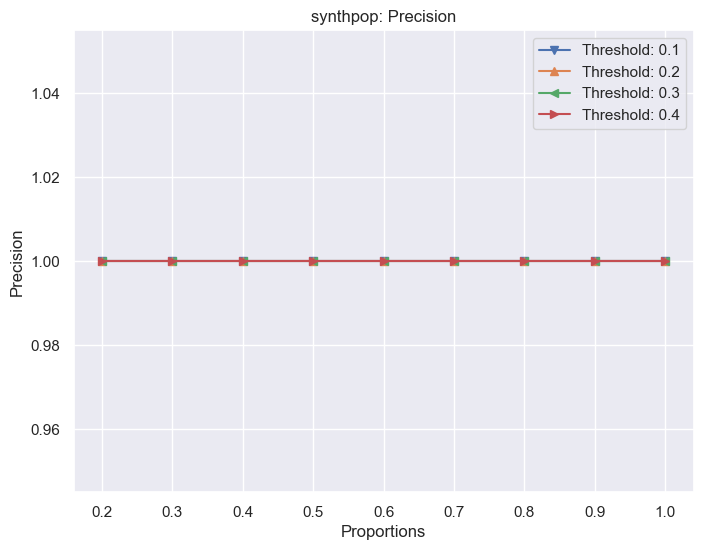

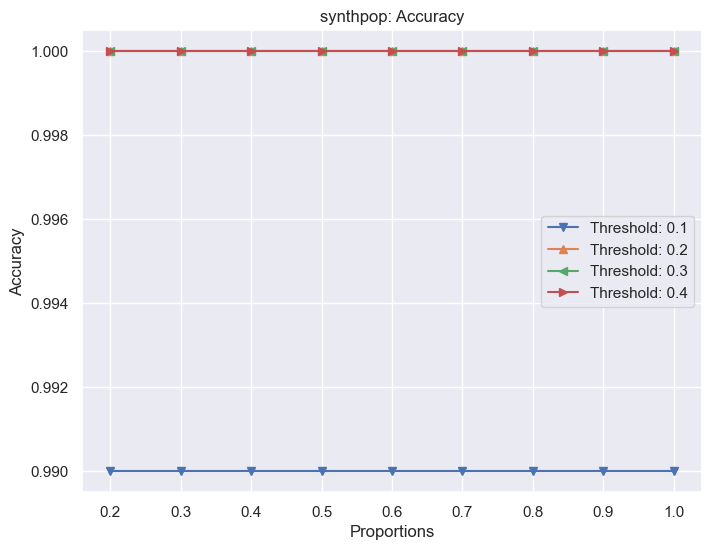

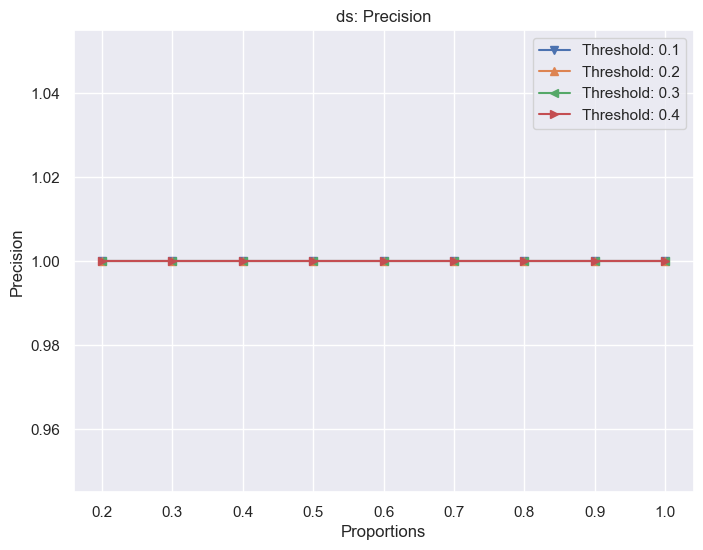

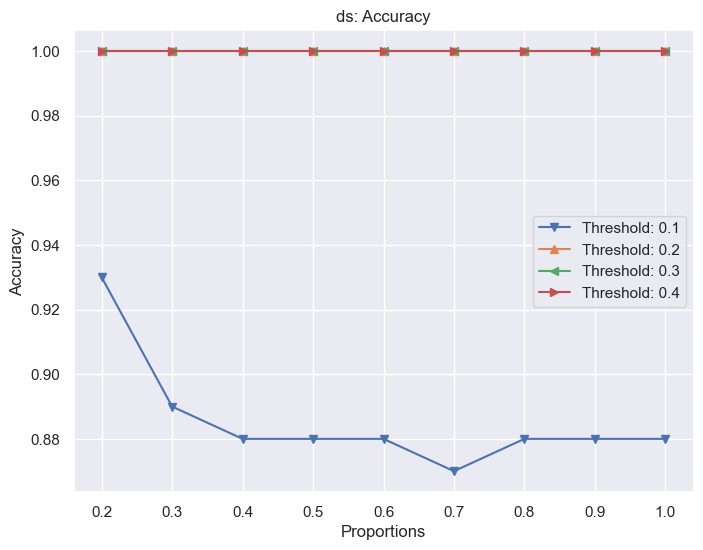

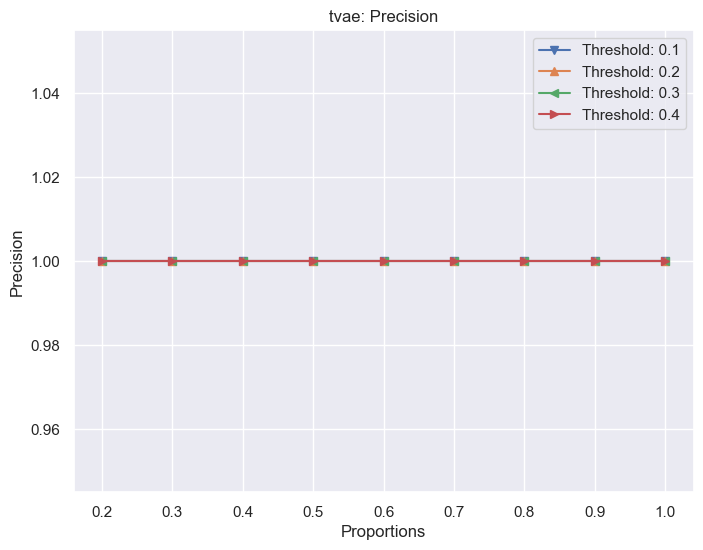

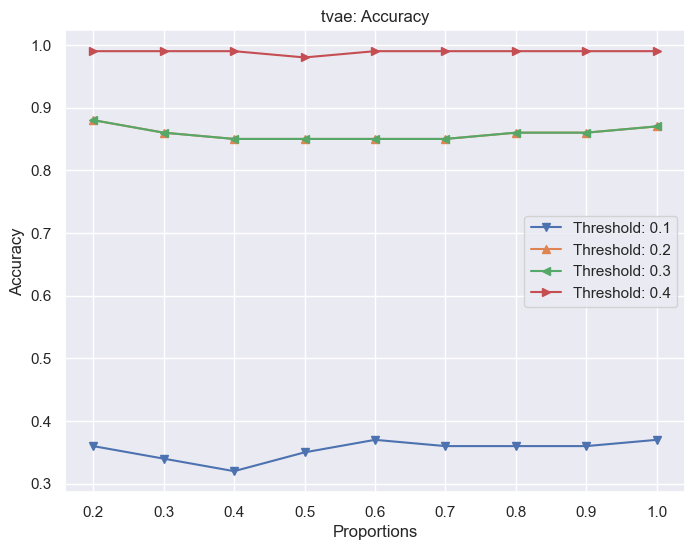

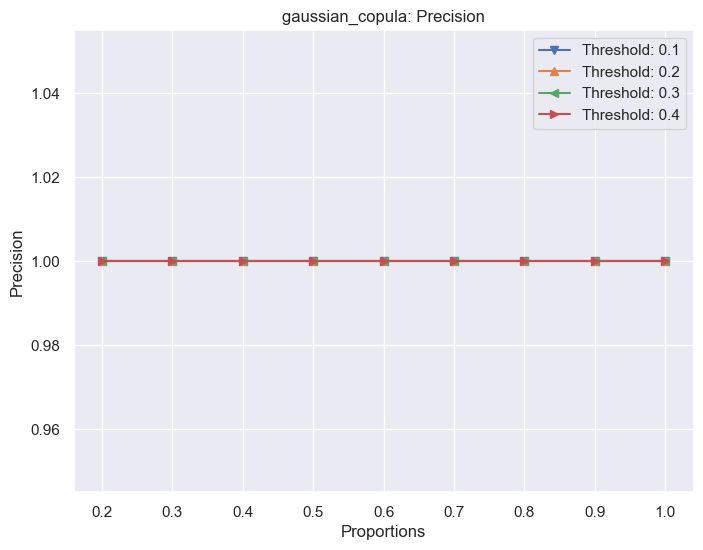

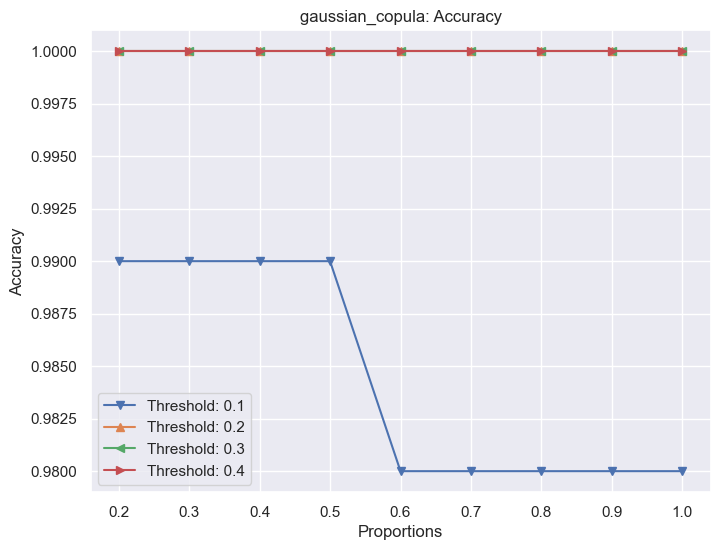

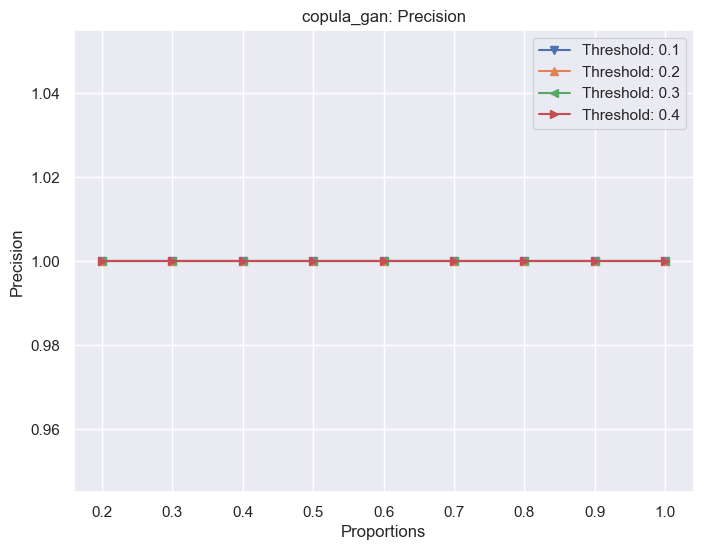

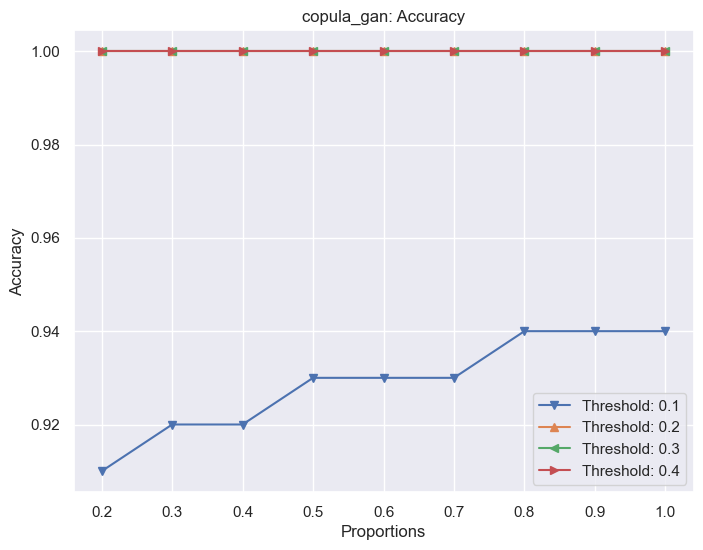

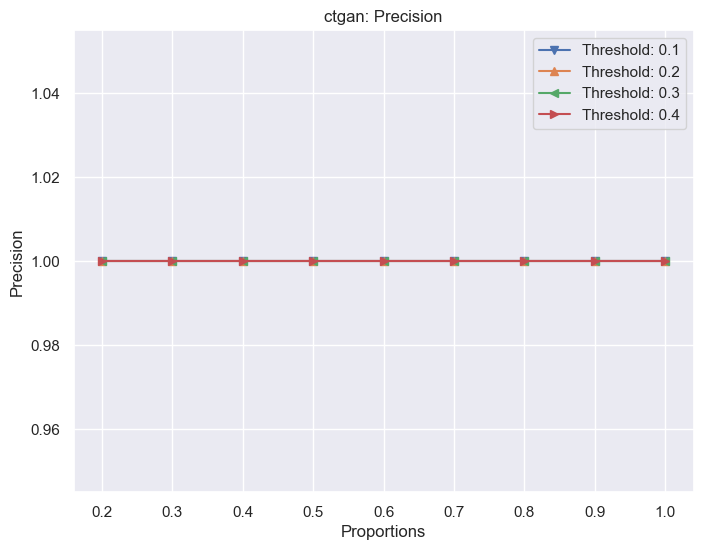

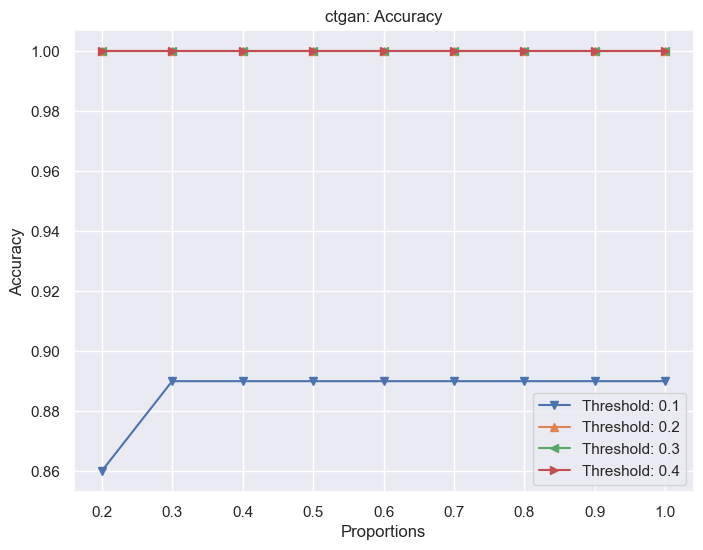

In [20]:
mia_results = {}
for i, model in enumerate(models):
    mia_results[model_names[i]] = mia(train_data, model, model_names[i], dataset_nr=2, save_plts=True)
